
# Min Graph Coloring Problem



## Background

Given a graph $G = (V,E)$, find the minimal number of colors k required to properly color it.
A coloring is legal if:

- each vetrex ${v_i}$ is assigned with a color $k_i \in \{0, 1, ..., k-1\}$
- adajecnt vertex have different colors: for each $v_i, v_j$ such that $(v_i, v_j) \in E$, $k_i \neq k_j$.
A graph which is k-colorable but not (k−1)-colorable is said to have chromatic number k. The maximum bound on the chromatic number is $D_G + 1$, where $D_G$ is the maximum vertex degree. The graph coloring problem is known to be in the NP-hard complexity class.

## Solving the problem with classiq



### Define the optimization problem


We encode the graph coloring with a matrix of variables `X` with dimensions $k \times |V|$ using one-hot encoding, such that a $X_{ki} = 1$ means that vertex i is colored by color k.

We require that each vertex is colored by exactly one color and that 2 adjacent vertices have different colors.

In [1]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_min_graph_coloring_model(graph, max_num_colors):
    model = pyo.ConcreteModel()

    nodes = list(graph.nodes())
    colors = range(0, max_num_colors)

    model.x = pyo.Var(colors, nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    adjacency_matrix_block_diagonal = np.kron(np.eye(degree_max), adjacency_matrix)

    model.conflicting_color_constraint = pyo.Constraint(
        expr=x_variables @ adjacency_matrix_block_diagonal @ x_variables == 0
    )

    @model.Constraint(nodes)
    def each_vertex_is_colored(model, node):
        return sum(model.x[color, node] for color in colors) == 1

    def is_color_used(color):
        is_color_not_used = np.prod([(1 - model.x[color, node]) for node in nodes])
        return 1 - is_color_not_used

    # minimize the number of colors in use
    model.value = pyo.Objective(
        expr=sum(is_color_used(color) for color in colors), sense=pyo.minimize
    )

    return model

### Initialize the model with example graph

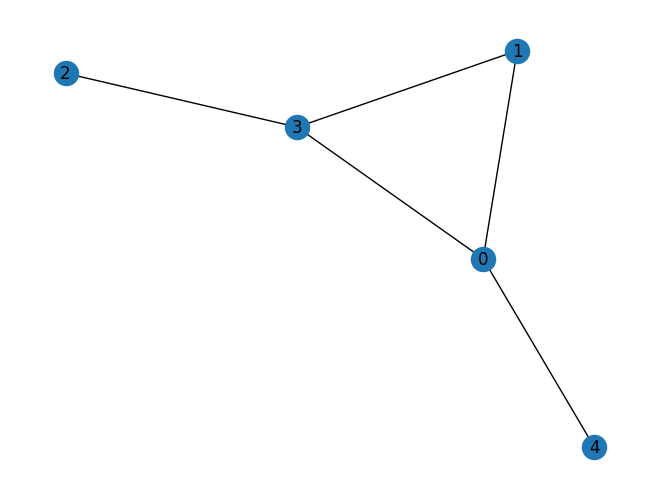

In [2]:
graph = nx.erdos_renyi_graph(5, 0.3, seed=79)
nx.draw_kamada_kawai(graph, with_labels=True)

degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)
degree_max = max(degree_sequence)
max_num_colors = degree_max

coloring_model = define_min_graph_coloring_model(graph, max_num_colors)

### show the resulting pyomo model

In [3]:
coloring_model.pprint()

4 Set Declarations
    each_vertex_is_colored_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   15 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}

1 Var Declarations
    x : Size=15, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : 

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` python class. Under the hood it translates the Pyomo model to a quantum model of the QAOA algorithm [[1](#QAOA)], with cost hamiltonian translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`.

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=coloring_model, num_layers=6, penalty_factor=10)

qmod = combi.get_model()

In [5]:
write_qmod(qmod, "min_graph_coloring")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2zJB0wcTNTkUTnKwKPK0f4G7edG


We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[2](#cvar)]:

In [7]:
optimized_params = combi.optimize(maxiter=100, quantile=0.7)

Optimization Progress: 101it [12:59,  7.72s/it]                                                                                                                                                                                                    


We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

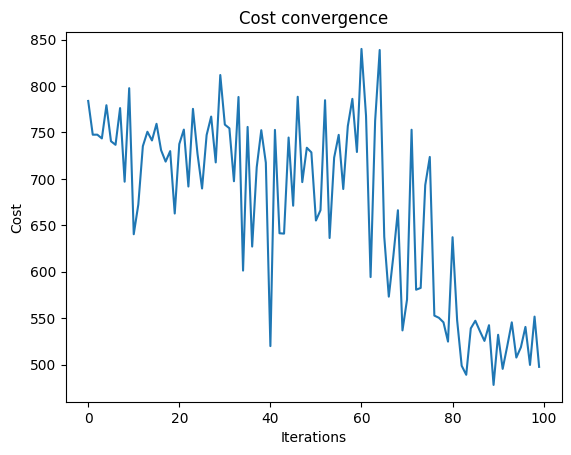

In [8]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

We can also examine the statistics of the algorithm. In order to get samples with the optimized parameters, we call the `sample` method:

In [9]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
957,"{'x': [[0, 1, 1, 0, 1], [1, 0, 0, 0, 0], [0, 0...",0.000488,3
1283,"{'x': [[0, 1, 1, 0, 0], [0, 0, 0, 1, 1], [1, 0...",0.000488,3
1499,"{'x': [[1, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1...",0.000488,3
376,"{'x': [[1, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0...",0.000488,3
1435,"{'x': [[1, 0, 1, 0, 0], [0, 0, 0, 1, 1], [0, 1...",0.000488,3


We will also want to compare the optimized results to uniformly sampled results:

In [10]:
uniform_result = combi.sample_uniform()

And compare the histograms:

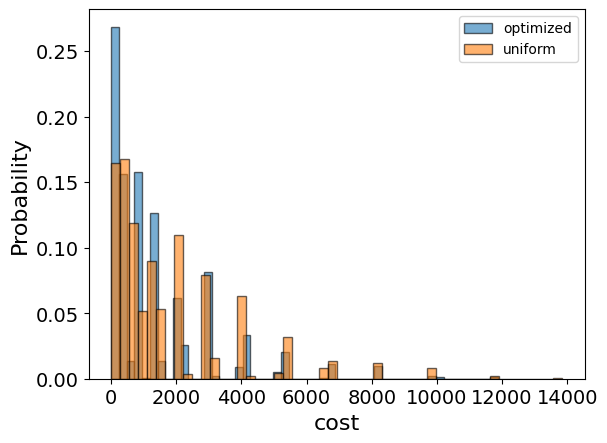

In [11]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x': [[1, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 1]]}

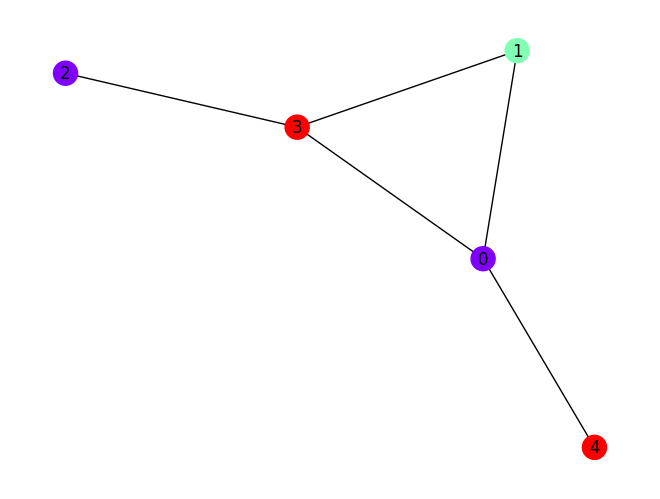

In [13]:
import matplotlib.pyplot as plt

best_solution = optimization_result.solution[optimization_result.cost.idxmin()]["x"]

one_hot_solution = np.array(best_solution).reshape([max_num_colors, len(graph.nodes)])
integer_solution = np.argmax(one_hot_solution, axis=0)
nx.draw_kamada_kawai(
    graph, with_labels=True, node_color=integer_solution, cmap=plt.cm.rainbow
)


## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[2]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
